现在开始 逻辑回归 模型的训练和评估...
折叠 1 ‘欺诈’类别F1分数: 0.853
折叠 2 ‘欺诈’类别F1分数: 0.857
折叠 3 ‘欺诈’类别F1分数: 0.805
折叠 4 ‘欺诈’类别F1分数: 0.884
折叠 5 ‘欺诈’类别F1分数: 0.866
逻辑回归 平均‘欺诈’类别F1分数: 0.853
逻辑回归 模型训练和评估完成，耗时 26.66 秒。

现在开始用整个训练集训练 逻辑回归 模型...
逻辑回归 模型训练完成，耗时 6.70 秒。


逻辑回归 分类报告:
              precision    recall  f1-score   support

         非欺诈       0.99      1.00      0.99      3395
          欺诈       0.92      0.85      0.88       181

    accuracy                           0.99      3576
   macro avg       0.95      0.92      0.94      3576
weighted avg       0.99      0.99      0.99      3576

现在开始 随机森林 模型的训练和评估...
折叠 1 ‘欺诈’类别F1分数: 0.760
折叠 2 ‘欺诈’类别F1分数: 0.781
折叠 3 ‘欺诈’类别F1分数: 0.751
折叠 4 ‘欺诈’类别F1分数: 0.795
折叠 5 ‘欺诈’类别F1分数: 0.803
随机森林 平均‘欺诈’类别F1分数: 0.778
随机森林 模型训练和评估完成，耗时 228.00 秒。

现在开始用整个训练集训练 随机森林 模型...
随机森林 模型训练完成，耗时 61.93 秒。


随机森林 分类报告:
              precision    recall  f1-score   support

         非欺诈       0.98      1.00      0.99      3395
          欺诈       1.00      0.64      0.78       181

    acc

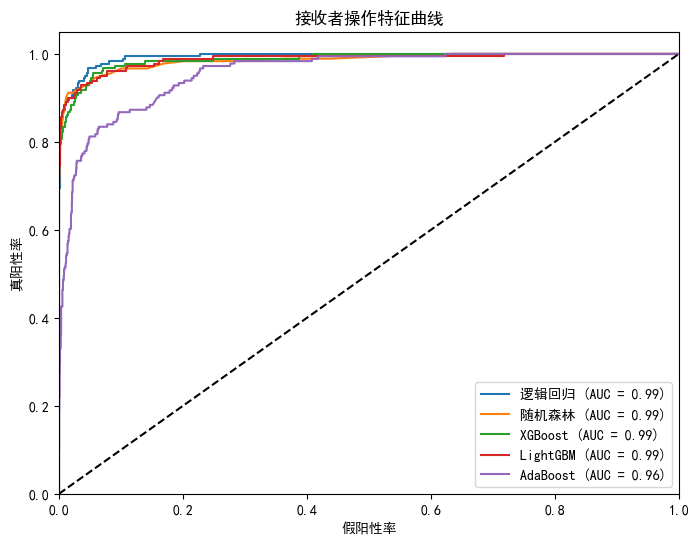

最佳模型是: LightGBM，平均‘欺诈’类别F1分数为: 0.862
LightGBM 的AUC分数为: 0.987


In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, roc_curve, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt

# 设置字体
plt.rcParams['font.sans-serif'] = ['SimHei']

# 加载数据
df = pd.read_csv(r'data\fake_job_postings.csv')
fill_value = "Missing"

columns_to_fill = ['title', 'location', 'description', 'requirements', 
                   'benefits', 'department', 'required_education', 
                   'industry', 'function', 'company_profile']

df[columns_to_fill] = df[columns_to_fill].fillna(fill_value)

# 文本字段拼接
df['text_combined'] = df[['title', 'location', 'description', 'requirements', 'benefits']].agg(' '.join, axis=1)
df['location'] = df['location'].str.strip().str.replace(' ,', ',').str.replace(', ', ',')

# 分割字段，并限制最大分割数为2，以确保最多获得3个部分
split_columns = df['location'].str.split(',', n=2, expand=True)

# 确保我们总是有三列，用空字符串填充缺失的部分
split_columns = split_columns.reindex(columns=[0, 1, 2]).fillna('')

# 重命名分割后的列
split_columns.columns = ['country', 'state', 'city']

# 将分割后的列加入到原数据框中
df = pd.concat([df, split_columns], axis=1)
# 使用两个独立的 TfidfVectorizer 实例
tfidf_text = TfidfVectorizer(stop_words='english')
tfidf_company_profile = TfidfVectorizer(stop_words='english')

X_text = tfidf_text.fit_transform(df['text_combined'])

# 对 company_profile 的 TF-IDF 特征进行放大处理
weight_factor = 5.0  # 调整这个因子以改变公司简介字段的重要性
X_company_profile = tfidf_company_profile.fit_transform(df['company_profile']).multiply(weight_factor)

# one-hot 编码类别变量
categorical_features = ['department', 'required_education', 'industry', 'function','city']
ohe = OneHotEncoder(handle_unknown='ignore')  # 确保未知类别的处理
X_categorical = ohe.fit_transform(df[categorical_features])

# 数值型特征
numerical_features = ['has_company_logo']
X_numerical = csr_matrix(df[numerical_features].values)

# 合并所有特征
X_final = hstack([X_text, X_company_profile, X_categorical, X_numerical])

# 准备标签
y = df['fraudulent']

# 计算company_profile字段的重要性权重，基于是否为 "Missing"
missing_weight_factor = 10.0  # 调整这个因子以改变 "Missing" 样本的重要性
df['company_profile_weight'] = df['company_profile'].apply(lambda x: missing_weight_factor if x == fill_value else 1)

# 划分训练集和测试集，同时分割样本权重
X_train, X_test, y_train, y_test, sample_weights_train, _ = train_test_split(
    X_final, y, df['company_profile_weight'], test_size=0.2, random_state=42)

# 定义一个自定义评分函数，专门用于计算“欺诈”类（标签为1）的F1分数
def fraud_f1_scorer(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1)

# 创建不同类型的分类器
classifiers = {
    "逻辑回归": LogisticRegression(class_weight=None, max_iter=1000, C=0.1),  # 增加正则化
    "随机森林": RandomForestClassifier(class_weight=None),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

best_clf = None
best_f1_fraud = 0
best_name = ""
roc_data = {}

for name, clf in classifiers.items():
    print(f"现在开始 {name} 模型的训练和评估...")
    start_time = time.time()  # 开始计时
    
    # 使用分层抽样进行交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(fraud_f1_scorer)
    
    scores = []
    for train_index, val_index in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        sample_weights_fold = sample_weights_train.iloc[train_index]

        # 应用SMOTE进行过采样
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # 对于SMOTE生成的新样本，我们给定一个默认权重
        new_sample_weights = np.ones(len(y_train_resampled))
        new_sample_weights[:len(sample_weights_fold)] = sample_weights_fold.values
        
        # 训练模型
        clf.fit(X_train_resampled, y_train_resampled, sample_weight=new_sample_weights)
        
        # 预测并计算分数
        y_pred = clf.predict(X_val_fold)
        score = scorer._score_func(y_val_fold, y_pred)
        scores.append(score)
    
    # 打印每次折叠的具体分数
    for i, score in enumerate(scores, 1):
        print(f"折叠 {i} ‘欺诈’类别F1分数: {score:.3f}")
    
    mean_f1_fraud = np.mean(scores)
    end_time = time.time()  # 结束计时
    elapsed_time = end_time - start_time  # 计算耗时
    print(f"{name} 平均‘欺诈’类别F1分数: {mean_f1_fraud:.3f}")
    print(f"{name} 模型训练和评估完成，耗时 {elapsed_time:.2f} 秒。\n")
    
    if mean_f1_fraud > best_f1_fraud:
        best_f1_fraud = mean_f1_fraud
        best_clf = clf
        best_name = name
    
    # 打印每个分类器的分类报告
    print(f"现在开始用整个训练集训练 {name} 模型...")
    start_time = time.time()  # 开始计时
    
    # 在整个训练集上应用相同的流程
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    new_sample_weights = np.ones(len(y_train_resampled))
    new_sample_weights[:len(sample_weights_train)] = sample_weights_train.values
    
    clf.fit(X_train_resampled, y_train_resampled, sample_weight=new_sample_weights)
    end_time = time.time()  # 结束计时
    elapsed_time = end_time - start_time  # 计算耗时
    print(f"{name} 模型训练完成，耗时 {elapsed_time:.2f} 秒。\n")

    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["非欺诈", "欺诈"], zero_division=0)
    print(f"\n{name} 分类报告:\n{report}")

    # 预测测试集的概率
    try:
        y_prob = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        # 如果分类器不支持概率预测，则使用decision_function方法
        y_prob = clf.decision_function(X_test)

    # 计算FPR, TPR 和 AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    # 存储ROC数据
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

# 绘制所有模型的ROC曲线
plt.figure(figsize=(8, 6))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{name} (AUC = {data["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # 对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('接收者操作特征曲线')
plt.legend(loc="lower right")
plt.show()

# 打印最佳模型的额外信息
print(f"最佳模型是: {best_name}，平均‘欺诈’类别F1分数为: {best_f1_fraud:.3f}")
print(f"{best_name} 的AUC分数为: {roc_data[best_name]['roc_auc']:.3f}")

#### 超参数调优

In [2]:
# 根据最佳模型名称设置超参数网格
if best_name == "逻辑回归":
    param_grid = {
        'C': [0.01, 0.1, 1, 10],  # 正则化强度
        'class_weight': [None, 'balanced'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
elif best_name == "随机森林":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_name == "XGBoost":
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
elif best_name == "LightGBM":
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200, 300]
    }
elif best_name == "AdaBoost":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }

print(f"准备对 {best_name} 模型进行网格搜索，使用的超参数网格如下：\n{param_grid}\n")

# 使用StratifiedKFold分层抽样
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("初始化分层K折交叉验证器完成。\n")

# 确保我们使用的是相同的随机状态以获得可重复的结果
np.random.seed(42)

# 定义一个自定义评分函数，专门用于计算‘欺诈’类（标签为1）的F1分数
def fraud_f1_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred, pos_label=1)

grid_search = GridSearchCV(
    estimator=best_clf,
    param_grid=param_grid,
    scoring=fraud_f1_scorer,  # 使用自定义评分函数
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True  # 确保在所有数据上使用最佳参数进行最终拟合
)

# 应用SMOTE进行过采样并进行网格搜索
smote = SMOTE(random_state=42)
print("应用SMOTE进行过采样...")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

new_sample_weights = np.ones(len(y_train_resampled))
new_sample_weights[:len(sample_weights_train)] = sample_weights_train.values

# 执行网格搜索...
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled, sample_weight=new_sample_weights)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\n网格搜索完成，耗时 {elapsed_time:.2f} 秒。\n")

# 输出最佳参数和对应的分数
print("网格搜索结果如下：")
print(f"最佳参数: {grid_search.best_params_}")

# 使用最佳参数重新训练模型并评估在测试集上的表现
best_clf_tuned = grid_search.best_estimator_

y_pred = best_clf_tuned.predict(X_test)

# 特别打印出‘欺诈’类别的F1分数
fraud_f1_test = f1_score(y_test, y_pred, pos_label=1)
print(f"\n最佳模型在测试集上的‘欺诈’类别F1分数: {fraud_f1_test:.3f}")

# 打印完整的分类报告
report = classification_report(y_test, y_pred, target_names=["非欺诈", "欺诈"], zero_division=0)
print(f"\n最佳模型分类报告:\n{report}")

准备对 LightGBM 模型进行网格搜索，使用的超参数网格如下：
{'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200, 300]}

初始化分层K折交叉验证器完成。

应用SMOTE进行过采样...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 13619, number of negative: 13619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.200039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877585
[LightGBM] [Info] Number of data points in the train set: 27238, number of used features: 16932
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349533 -> initscore=-0.621091
[LightGBM] [Info] Start training from score -0.621091

网格搜索完成，耗时 1459.41 秒。

网格搜索结果如下：
最佳参数: {'learning_rate': 0.1, 'n_estimators': 300}

最佳模型在测试集上的‘欺诈’类别F1分数: 0.884

最佳模型分类报告:
              precision    recall  f1-score   support

         非欺诈       0.99      1.00      0.99      3395
          欺诈       0.96      0.82      0.88       181

    accuracy          